## Introduction

This notebook is designed to train PrePR-CT and reproduce the results using the Kang dataset. Before running the notebook, please ensure you have set the correct paths for the input and output files:

- **Data Path**: The location of the dataset files.
- **Results Path**: The directory where the output results will be saved.
- **Models Path**: The directory to save model checkpoints.
- **parent_dir**: The location of the cell type graphs

```python
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"
parent_dir = "Cell-Type-Specific-Graphs/graphs/"


In [1]:
import torch
import torch; print(torch.__version__)
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import *
import scanpy as sc 
import pandas as pd
import os
import sys
import numpy as np
import gzip
import pickle
import random
import matplotlib.pyplot as pl
from statistics import mode
from numpy.random import RandomState
import re
import seaborn as sns
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn import preprocessing
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *

import model
from importlib import reload
reload(model)
from model import *
data_path = "Cell-Type-Specific-Graphs/Data/"
save_path_results = "Cell-Type-Specific-Graphs/Results/"
save_path_models = "Cell-Type-Specific-Graphs/model_checkpoints/"

1.13.1+cu117


2024-11-05 11:06:02.856755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-11-05 11:06:07.977706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Import the Data

In [2]:
adata = sc.read(data_path+'Kang.h5ad')
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond', 'SEACell', 'dose_value', 'cov_drug', 'condition_label', 'split'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'gene_network', 'hvg', 'log1p', 'neighbors', 'pca', 'rank_genes_groups_cov_DEGs', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
print(len(adata.obs.loc[adata.obs.condition == 'control']), len(adata.obs.loc[adata.obs.condition != 'control']))
print(len(adata.obs.loc[adata.obs.condition == 'control']) + len(adata.obs.loc[adata.obs.condition != 'control']))

12388 11861
24249


## Import the Cell Type Graphs in a Dictionary Form

In [4]:
cell_type_network = {}
# Leaf directory 
directory = "Kang"
# Parent Directories 
parent_dir = "Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/Kang
File exists!
CD14+ Monocytes
CD4 T cells
Dendritic cells
NK cells
CD8 T cells
B cells
FCGR3A+ Monocytes
3924


{'CD14+ Monocytes': Data(x=[3499, 60], edge_index=[2, 246170], edge_attr=[246170], pos=[3499]),
 'CD4 T cells': Data(x=[3728, 81], edge_index=[2, 245444], edge_attr=[245444], pos=[3728]),
 'Dendritic cells': Data(x=[3199, 15], edge_index=[2, 246792], edge_attr=[246792], pos=[3199]),
 'NK cells': Data(x=[3794, 12], edge_index=[2, 246206], edge_attr=[246206], pos=[3794]),
 'CD8 T cells': Data(x=[3924, 17], edge_index=[2, 246030], edge_attr=[246030], pos=[3924]),
 'B cells': Data(x=[3291, 43], edge_index=[2, 246068], edge_attr=[246068], pos=[3291]),
 'FCGR3A+ Monocytes': Data(x=[3327, 19], edge_index=[2, 246674], edge_attr=[246674], pos=[3327])}

## Compute DEGs per cell type and drug

In [5]:
adata.uns['gene_network'] = {}
adata.uns['rank_genes_groups_cov_DEGs'] = {}
for cell_type in adata.obs.cov_drug.unique():
    if cell_type.split('_')[1] != 'control':
        adata_cov = adata[adata.obs.cell_type == cell_type.split('_')[0], cell_type_network[cell_type.split('_')[0]].pos.tolist()].copy()
        adata_cov.uns['log1p']['base'] = None
        sc.tl.rank_genes_groups(adata_cov, groupby = 'cov_drug',rankby_abs = True,
                                        reference = cell_type.split('_')[0]+'_control',n_genes = len(adata_cov.var))
        dedf = sc.get.rank_genes_groups_df(adata_cov, group=cell_type)
        dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
        DEGs_name = rank_genes(dedf)
        df = adata_cov.var.reset_index()
        adata.uns['gene_network'][cell_type] = df.index.values
        adata.uns['rank_genes_groups_cov_DEGs'][cell_type] = DEGs_name
        pd.DataFrame(DEGs_name).to_csv(save_path_results+"Kang_"+cell_type+"_DEGs_name.csv")
        pd.DataFrame(adata_cov.var.index.values).to_csv(save_path_results+"Kang_"+cell_type+"_all_genes.csv")

## Split the data 

In [6]:
testing_cell = 'B cells'
adata.obs['split'] = 'train'
adata.obs.loc[ (adata.obs.cell_type == testing_cell) & (adata.obs.condition != "control"), 'split'] = 'ood'
valid_idx = sc.pp.subsample(adata[ (adata.obs['split'] != "ood") & (adata.obs.condition != "control") ], 0.10, copy=True, random_state = 42).obs.index
adata.obs["split"].loc[valid_idx] = "valid"
display(adata.obs.split.value_counts())

/tmp/ipykernel_414790/772087623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["split"].loc[valid_idx] = "valid"


split
train    21956
ood       1230
valid     1063
Name: count, dtype: int64

## Match Control to Treatment Cells

In [7]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
ctrl_data = adata[adata.obs.condition == 'control'].copy()
# Use the mean & std of the control cells as a feature matrix for cell type graph
for count, cell_type in enumerate(adata.obs.cell_type.unique()):
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    

# Matching
prng = RandomState()
for cov_drug in stim_data.obs.cov_drug.unique():
    cell_type = cov_drug.split('_')[0]
    # matching between control and treatment using SEACells clusters 
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsula

## Save the data in a form of PyG Data objects to train GNN

In [8]:
cells_train = create_cells(stim_data[stim_data.obs.split == 'train'].copy(),cell_type_network, None)
cells_valid = create_cells(stim_data[stim_data.obs.split == 'valid'].copy(),cell_type_network, None)
cells_ood = create_cells(stim_data[stim_data.obs.split == 'ood'].copy(),cell_type_network, None)

with open(data_path+'cells_train_Kang.pkl', 'wb') as f:
    pickle.dump(cells_train, f)
with open(data_path+'cells_valid_Kang.pkl', 'wb') as f:
    pickle.dump(cells_valid, f)
with open(data_path+'cells_ood_Kang.pkl', 'wb') as f:
    pickle.dump(cells_ood, f)

['CD8 T cells', 'Dendritic cells', 'CD4 T cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']
Categories (6, object): ['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells'] ['stimulated']
Categories (1, object): ['stimulated']


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/4614 [00:00<?, ?it/s]

  0%|          | 0/2254 [00:00<?, ?it/s]

  0%|          | 0/924 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

['CD14+ Monocytes', 'CD4 T cells', 'NK cells', 'CD8 T cells', 'FCGR3A+ Monocytes', 'Dendritic cells']
Categories (6, object): ['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells'] ['stimulated']
Categories (1, object): ['stimulated']


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['B cells']
Categories (1, object): ['B cells'] ['stimulated']
Categories (1, object): ['stimulated']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1230 [00:00<?, ?it/s]

In [9]:
with open(data_path+'cells_train_Kang.pkl', 'rb') as pickle_file:
    cells_train = pickle.load(pickle_file)

with open(data_path+'cells_valid_Kang.pkl', 'rb') as pickle_file:
    cells_valid = pickle.load(pickle_file)
# 
with open(data_path+'cells_ood_Kang.pkl', 'rb') as pickle_file:
    cells_ood = pickle.load(pickle_file)
    
print(len(cells_train), len(cells_valid), len(cells_ood))

9568 1063 1230


## Train & test the model 

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training Starts


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0, train loss: 10.99954705011277


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1, train loss: 8.127469176337833


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2, train loss: 7.704198303676787


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3, train loss: 7.51561316989717


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4, train loss: 7.359427429380871


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5, train loss: 7.246088924862089


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6, train loss: 7.086181527092343


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7, train loss: 6.911191100165958


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8, train loss: 6.7113101822989325


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9, train loss: 6.517402319681077


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10, train loss: 6.365656682423183


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11, train loss: 6.138827074141729


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12, train loss: 5.945036876769293


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13, train loss: 5.748072885331654


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14, train loss: 5.575195902869815


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15, train loss: 5.380371014277141


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16, train loss: 5.22444638751802


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17, train loss: 5.057453291756766


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18, train loss: 4.9118876457214355


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19, train loss: 4.8001492250533335


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20, train loss: 4.6637487297966365


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 21, train loss: 4.551211379823231


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 22, train loss: 4.455472071965535


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 23, train loss: 4.337209156581333


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 24, train loss: 4.252614611671085


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 25, train loss: 4.1693869431813555


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 26, train loss: 4.091925802684965


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 27, train loss: 4.018947453725906


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 28, train loss: 3.950580534480867


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 29, train loss: 3.8904077666146413


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 30, train loss: 3.8309071347827004


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 31, train loss: 3.7874218282245455


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 32, train loss: 3.7364891653969172


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 33, train loss: 3.6926196075621105


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 34, train loss: 3.640229032153175


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 35, train loss: 3.611877191634405


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 36, train loss: 3.5724287146613714


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 37, train loss: 3.5297880456561135


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 38, train loss: 3.493260900179545


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 39, train loss: 3.4690967344102406


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 40, train loss: 3.439880547069368


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 41, train loss: 3.4318124055862427


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 42, train loss: 3.3995162418910434


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 43, train loss: 3.365652703103565


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 44, train loss: 3.345383490834917


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 45, train loss: 3.3177082992735363


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 46, train loss: 3.3128133614857993


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 47, train loss: 3.2856819856734503


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 48, train loss: 3.290544413384937


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 49, train loss: 3.2602358091445196


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 50, train loss: 3.261265272185916


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 51, train loss: 3.224995119231088


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 52, train loss: 3.214313660349165


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 53, train loss: 3.1752877916608537


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 54, train loss: 3.17219953309922


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 55, train loss: 3.1894643079666865


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 56, train loss: 3.1691618817193166


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 57, train loss: 3.140927939187913


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 58, train loss: 3.1456961120877946


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 59, train loss: 3.11779522895813


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 60, train loss: 3.104553852762495


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 61, train loss: 3.0990898382096064


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 62, train loss: 3.0927497432345437


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 63, train loss: 3.0831958509626842


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 64, train loss: 3.083638236636207


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 65, train loss: 3.0914552552359447


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 66, train loss: 3.0748043003536405


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 67, train loss: 3.053186615308126


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 68, train loss: 3.06403911113739


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 69, train loss: 3.0690464803150723


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 70, train loss: 3.0322680530093966


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 71, train loss: 3.022385761851356


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 72, train loss: 3.0303706044242498


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 73, train loss: 3.024060924847921


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 74, train loss: 3.0075579427537464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 75, train loss: 3.029508732614063


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 76, train loss: 3.00815516994113


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 77, train loss: 3.000132066862924


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 78, train loss: 2.9909538598287675


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 79, train loss: 2.987808590843564


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 80, train loss: 2.990889850116911


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 81, train loss: 2.986833549681164


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 82, train loss: 2.969769154276167


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 83, train loss: 2.9741160415467762


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 84, train loss: 2.967008250100272


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 85, train loss: 2.9488071430297125


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 86, train loss: 2.95541589033036


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 87, train loss: 2.9632724750609625


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 88, train loss: 2.9501119000571117


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 89, train loss: 2.9406704618817283


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 90, train loss: 2.945129530770438


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 91, train loss: 2.947290744100298


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 92, train loss: 2.953440711611793


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 93, train loss: 2.9449908563068936


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 94, train loss: 2.9310294560023715


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 95, train loss: 2.951243934177217


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 96, train loss: 2.928891244388762


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 97, train loss: 2.9487326599302746


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 98, train loss: 2.930587161154974


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 99, train loss: 2.9360507272538685


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9937271466439994
R2 top 50 DEGs:  0.9975167175447193
R2 all genes:  0.9862137091913343
R2 top 100 DEGs:  0.9936949020102138
3291


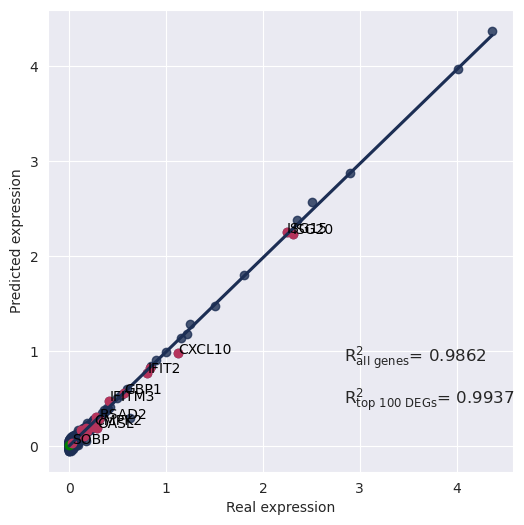

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

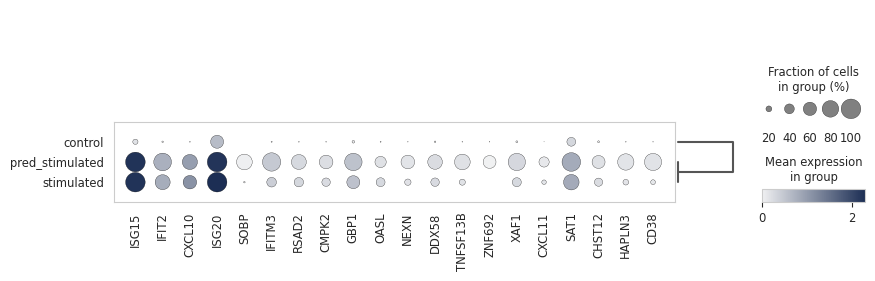

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9512995293618159
R2 top 50 DEGs:  0.9145924016169844
R2 all genes:  0.7885078915760203
R2 top 100 DEGs:  0.8784984934767678
3291


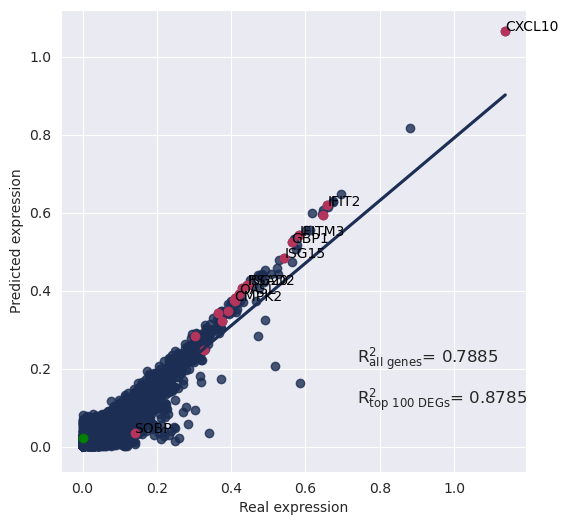

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


<Figure size 640x480 with 0 Axes>

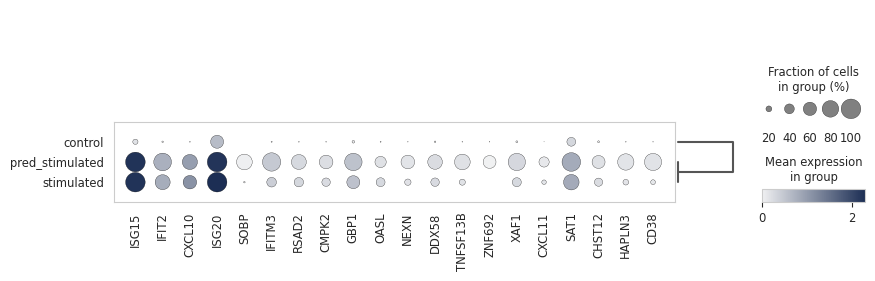

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
from importlib import reload
import utils
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *
import optuna

testing_drug = 'stimulated'
torch.manual_seed(42)
params = {'hidden_channels': 64, 'weight_decay': 1e-05, 'in_head': 1, 'learning_rate': -3, 'num_epochs': 100, 'batch_size': 256}
train_dataloader = DataLoader(cells_train+cells_valid, batch_size=params['batch_size'], shuffle=True)
model = GNN(total_genes  = len(adata.var), num_perts = num_perts, 
            hidden_channels = params['hidden_channels'], in_head = params['in_head']).to(device)
model = train(model = model, num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
              weight_decay = params['weight_decay'],
              cell_type_network = cell_type_network, train_loader = train_dataloader, multi_pert = False)
torch.save(model.state_dict(), save_path_models+'_'+testing_cell+"_Kang_model.pt")
model.load_state_dict(torch.load(save_path_models+'_'+testing_cell+"_Kang_model.pt"))
r2_all_avg = []
r2_degs_avg = []
r2_all_std = []
r2_degs_std = []
pred_adata = []
ood_loader_all = DataLoader(cells_ood, batch_size=len(cells_ood), shuffle=False)
oods_cells = np.array(next(iter(ood_loader_all)).cell_type)
for ood_cells in tq.tqdm(set(oods_cells)):
    index_cell_type = np.where(oods_cells == ood_cells)[0]
    data_ood = [cells_ood[i] for i in index_cell_type]
    ood_loader_cell_type = DataLoader(data_ood, batch_size=len(data_ood), shuffle=False)
    r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
               save_path_results+"Kang_mean_"+testing_drug, ood_loader_cell_type, 
               ood_cells, adata, testing_drug = testing_drug, 
               degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cells+'_'+testing_drug],
                                                      mean_or_std = True, plot = True, multi_pert = False)
    r2_all_avg.append(r2_all)
    r2_degs_avg.append(r2_DEGs)
    #---------------------------------------------------------------------------------------------------------
    r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
               save_path_results+"Kang_std_"+testing_drug, ood_loader_cell_type, 
               ood_cells, adata, testing_drug = testing_drug, 
               degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cells+'_'+testing_drug],
                                                      mean_or_std = False, plot = True, multi_pert = False)
    r2_all_std.append(r2_all)
    r2_degs_std.append(r2_DEGs)
    pred_adata.append(dot_adata)
pred_adata.append(adata[adata.obs.cov_drug == testing_cell+'_control', cell_type_network[testing_cell].pos.tolist()].copy())

## Visualize the UMAP of Observed and Predicted Expression

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False,

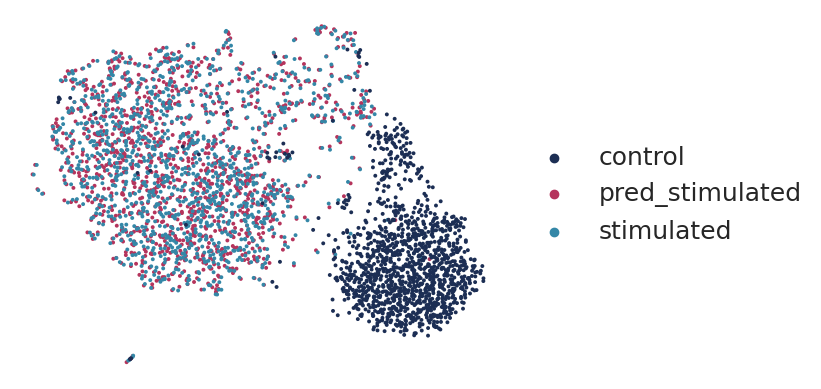

In [11]:
pred_adata_all = sc.concat(pred_adata, join='outer')

pred_adata_all.obs['Condition'] = 'stimulated'
pred_adata_all.obs.loc[pred_adata_all.obs.condition == 'control','Condition'] = 'control'
pred_adata_all.obs.loc[pred_adata_all.obs['condition'].str.startswith('pred'), 'Condition'] = 'pred_stimulated'
pred_adata_all.obs.rename(columns={'Condition': 'Treatment'}, inplace=True) 

sc.pp.neighbors(pred_adata_all)
sc.tl.umap(pred_adata_all) 
fig, ax = plt.subplots()
custom_colors = {'control': '#1C2E54', 'stimulated': '#B5345C', 'pred_stimulated':'#3487A7'}
sc.pl.umap(pred_adata_all, color='Treatment',  ax=ax, show=False, palette=list(custom_colors.values()), frameon=False, legend_fontsize=18)
# Remove the box (spines) around the plot
plt.savefig(save_path_results+"UMAP_Pred_Kang.pdf", bbox_inches='tight')
ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [12]:
# pred_adata_all.write('cell_type_graphs_WS/training/Kang_pred.h5ad')
# pred_adata_all

In [13]:
# from scipy import stats
# from torch_geometric.utils import to_undirected, is_undirected
# import matplotlib.pyplot as plt
# import umap


# # Function to remove self-loops
# def remove_self_loops(indices, values):
#     mask = indices[0] != indices[1]
#     indices = indices[:, mask]
#     values = values[mask]
#     return indices, values
# attn = {}
# plt.figure(figsize=(13,11))
# with torch.no_grad():
#     model.eval()
#     celltypes = adata.obs.cell_type.unique()
#     for key in celltypes:
#         print(key)
#         print(is_undirected(cell_type_network[key].edge_index))      
#         # Function to remove self-loops
#         x = cell_type_network[key].x.to('cuda')
#         x, w = model.conv1(x, cell_type_network[key].edge_index.to('cuda'), return_attention_weights = True)
#         indices, values = remove_self_loops(w[0], w[1])
#         values = values.squeeze()
#         print(cell_type_network[key].edge_attr.shape, values.shape, indices.shape)
#         nodes = torch.unique(indices[0])
#         # Initialize an empty tensor for storing averaged weights
#         averaged_weights = torch.zeros_like(nodes, dtype=torch.float)
#         # Iterate over nodes and calculate the sum weight for outgoing edges
#         num_edges = torch.zeros_like(nodes, dtype=torch.float)
#         for node in nodes:
#             mask = indices[0] == node
#             node_weights = (values[mask]).abs()
#             averaged_weight = torch.sum(node_weights)
#             averaged_weights[node] = averaged_weight
#             num_edges[node] = (int(len(node_weights)))
            
#         averaged_weights = averaged_weights.cpu()
#         values, indices_averaged_weights = torch.topk(averaged_weights, len(averaged_weights))
#         gene_name = adata.var_names[cell_type_network[key].pos[indices_averaged_weights].tolist()].values
#         attn[key] = pd.DataFrame({'Gene': gene_name, 'Rank': values, 'num_edges_outgoing': num_edges[indices_averaged_weights].tolist()})
#         res = stats.spearmanr(attn[key].Rank.values, attn[key].num_edges_outgoing.values)
#         print(key, res.statistic)

In [14]:
# import pickle

# # Save dictionary to a file
# with open(save_path_results+'attn_genes.pkl', 'wb') as pickle_file:
#     pickle.dump(attn, pickle_file)

# # Load dictionary from the file
# with open(save_path_results+'attn_genes.pkl', 'rb') as pickle_file:
#     loaded_data = pickle.load(pickle_file)

# print(loaded_data)